In [1]:
# @title
# !pip install dowhy econml --quiet

In [2]:
# @title
import statsmodels.formula.api as smf
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from scipy import stats
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from dowhy import CausalModel
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import graphviz

COLORS = [
    '#00B0F0',
    '#FF0000'
]

In [3]:
clientes = pd.read_csv("https://raw.githubusercontent.com/caalvaro/tcc-inferencia-causal/refs/heads/main/datasets/software_promotion_alterado.csv")

clientes.head()

,global_flag,size,employee_count,tech_support,revenue
0,1,152205,26,0,10078.11300
1,0,159038,107,0,7029.53559
2,0,264935,10,1,19670.38894
3,0,77522,40,1,10897.66855
4,0,91446,37,1,12526.39823


In [4]:
treatment = 'tech_support'
outcome = 'revenue'
covariates = ['global_flag', 'size', 'employee_count']

In [5]:
train, test = train_test_split(clientes, random_state=1, stratify=clientes['tech_support'])

# HTE

## Passo 1: Modelagem do grafo

In [6]:
gml_graph = """
graph [
    directed 1

    node [
        id "tech_support"
        label "tech_support"
    ]
    node [
        id "global_flag"
        label "global_flag"
    ]
    node [
        id "employee_count"
        label "employee_count"
    ]
    node [
        id "size"
        label "size"
    ]
    node [
        id "revenue"
        label "revenue"
    ]

    edge [
        source "tech_support"
        target "revenue"
    ]
    edge [
        source "global_flag"
        target "revenue"
    ]
    edge [
        source "employee_count"
        target "revenue"
    ]
    edge [
        source "size"
        target "revenue"
    ]

    edge [
        source "size"
        target "tech_support"
    ]
    edge [
        source "global_flag"
        target "tech_support"
    ]
    edge [
        source "employee_count"
        target "tech_support"
    ]
]
"""

In [7]:
# With graph
model = CausalModel(
    data = train,
    treatment = treatment,
    outcome = outcome,
    effect_modifiers=['size'],
    graph = gml_graph
)

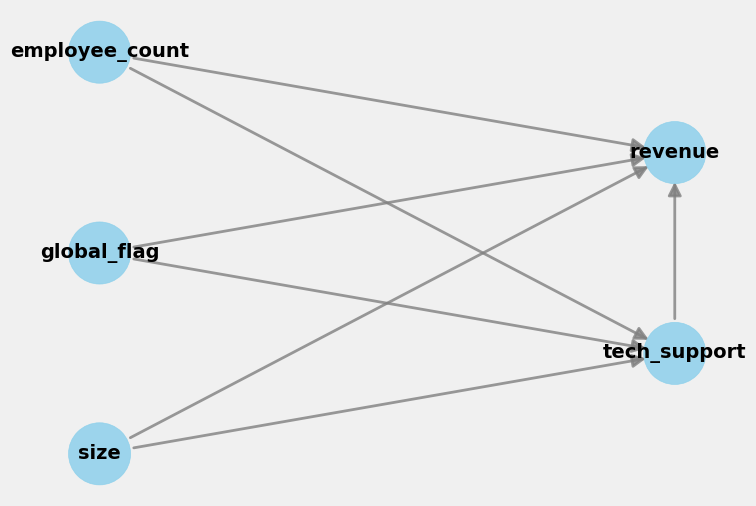

In [8]:
model.view_model()

## Passo 2: Obter o estimando

In [9]:
estimand = model.identify_effect()
print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                                   
──────────────(E[revenue|size,global_flag,employee_count])
d[techₛᵤₚₚₒᵣₜ]                                            
Estimand assumption 1, Unconfoundedness: If U→{tech_support} and U→revenue then P(revenue|tech_support,size,global_flag,employee_count,U) = P(revenue|tech_support,size,global_flag,employee_count)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Passo 3: Calcular a estimativa

In [10]:
from sklearn.linear_model import LinearRegression, LogisticRegression

Y = train[outcome].ravel()
T = train[treatment]
X = train[['size']]
W = train[['global_flag', 'employee_count']]

estimate = model.estimate_effect(
    identified_estimand = estimand,
    method_name="backdoor.econml.dml.CausalForestDML",
    method_params={
        "init_params": {'model_y': LinearRegression(),
                        'model_t': LogisticRegression(max_iter=10000, random_state=1),
                        'n_estimators': 64,
                        'max_depth':2,
                        # 'max_samples':0.5,
                        'random_state': 123,
                        'discrete_treatment': True,
                        'honest': True,
                        'cv': 5,
                        'criterion': 'het'
        },
        "fit_params": {}
    },
    effect_modifiers = ['size'],
    target_units = "att"
)

In [11]:
import statsmodels.formula.api as smf


linear_model = smf.ols("revenue ~ tech_support+ size + employee_count + global_flag", data=train).fit()
print(linear_model.summary().tables[1])

                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         93.2778     90.583      1.030      0.303     -84.406     270.961
tech_support    6888.3788     92.605     74.385      0.000    6706.729    7070.028
size               0.0449      0.000     97.688      0.000       0.044       0.046
employee_count    40.4590      0.805     50.264      0.000      38.880      42.038
global_flag     3926.0887    109.733     35.778      0.000    3710.841    4141.336


# Avaliação do modelo

In [12]:
from sklearn.ensemble import GradientBoostingRegressor

features = ["global_flag", "employee_count", "size", "tech_support"]
target = "revenue"

previsao = GradientBoostingRegressor(random_state=1) 
previsao.fit(train[features], train[target])

GradientBoostingRegressor(random_state=1)

In [13]:
print("Train Score:", previsao.score(train[features], train[target]))
print("Test Score:", previsao.score(test[features], test[target]))

Train Score: 0.9686508196728069
Test Score: 0.948495117775296


In [14]:
def predict_sensitivity(model, clientes_df):
    return model.effect(clientes_df)

  
np.random.seed(123)

test_pred = test.assign(**{
    "custo": test['employee_count'] * 100,
    "modelo_causal": estimate.estimator.effect(test[covariates]),
    "modelo_preditivo": previsao.predict(test[features]),
    "modelo_aleatorio": np.random.uniform(size=test.shape[0]),
    "retorno": estimate.estimator.effect(test[covariates]) - (test['employee_count'] * 100).to_numpy().reshape(-1,1)
}
).reset_index(drop=True)

test_pred.head(20)

test_pred.sort_index().head()

,global_flag,size,employee_count,tech_support,revenue,custo,modelo_causal,modelo_preditivo,modelo_aleatorio,retorno
0,1,180594,102,1,25989.206030,10200,8326.553898,23070.557305,0.696469,-1873.446102
1,0,14010,141,1,10357.277980,14100,5530.465435,13578.320637,0.286139,-8569.534565
2,0,324495,20,0,9269.751600,2000,10434.591712,11373.994310,0.226851,8434.591712
3,1,305435,18,1,28340.856060,1800,10006.881605,24850.837243,0.551315,8206.881605
4,0,14964,32,0,1456.970846,3200,5608.069774,2924.496914,0.719469,2408.069774


In [15]:
import statsmodels.formula.api as smf

# def sensitivity(df):
#     return smf.ols("revenue ~ tech_support*size + employee_count + global_flag", data=df).fit().params['tech_support']*df['tech_support'].mean() \
#             + smf.ols("revenue ~ tech_support*size + employee_count + global_flag", data=df).fit().params['tech_support:size']*df['size'].mean()*df['tech_support'].mean()

def sensitivity(df):
    return smf.ols("revenue ~ tech_support + size + employee_count + global_flag", data=df).fit().params['tech_support']

def sensitivity_by_band(df, pred, bands=5):
    return (df
            .assign(**{f"{pred}_band":pd.qcut(df[pred], q=bands)})
            .groupby(f"{pred}_band")
            .apply(sensitivity))

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


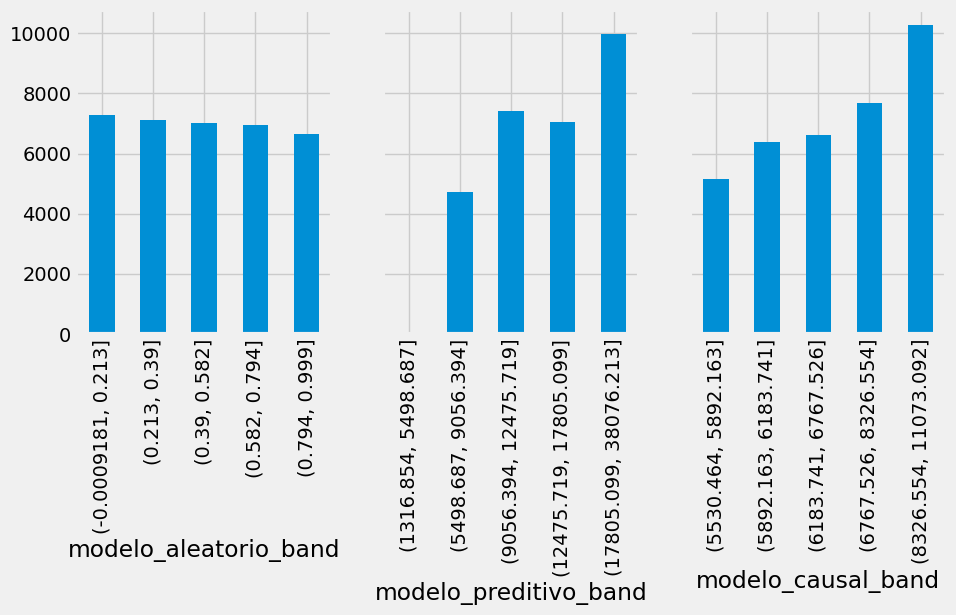

In [16]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(10, 4))
for m, ax in zip(["modelo_aleatorio", "modelo_preditivo", "modelo_causal"], axs):
    sensitivity_by_band(test_pred, m).plot.bar(ax=ax)

In [17]:
def cumulative_sensitivity_curve(dataset, prediction, min_periods=30, steps=100):
    size = dataset.shape[0]

    # orders the dataset by the `prediction` column
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)

    # create a sequence of row numbers that will define our Ks
    # The last item is the sequence is all the rows (the size of the dataset)
    n_rows = list(range(min_periods, size, size // steps)) + [size]

    # cumulative computes the sensitivity. First for the top min_periods units.
    # then for the top (min_periods + step*1), then (min_periods + step*2) and so on
    return np.array([sensitivity(ordered_df.head(rows)).mean() for rows in n_rows])

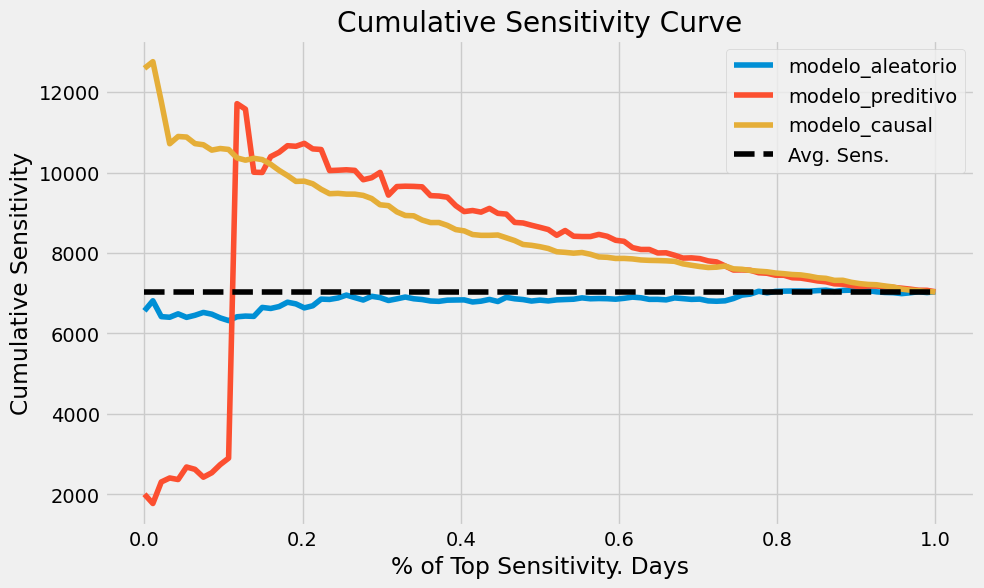

In [18]:
plt.figure(figsize=(10,6))

for m in ["modelo_aleatorio", "modelo_preditivo", "modelo_causal"]:
    cumu_sens = cumulative_sensitivity_curve(test_pred, m, min_periods=30, steps=100)
    x = np.array(range(len(cumu_sens)))
    plt.plot(x/x.max(), cumu_sens, label=m)

plt.hlines(cumu_sens[-1], 0, 1, linestyles="--", color="black", label="Avg. Sens.")
plt.xlabel("% of Top Sensitivity. Days")
plt.ylabel("Cumulative Sensitivity")
plt.title("Cumulative Sensitivity Curve")
plt.legend();

In [19]:
def cumulative_gain(dataset, prediction, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]

    ## add (rows/size) as a normalizer.
    return np.array([sensitivity(ordered_df.head(rows)).mean() * (rows/size) for rows in n_rows])

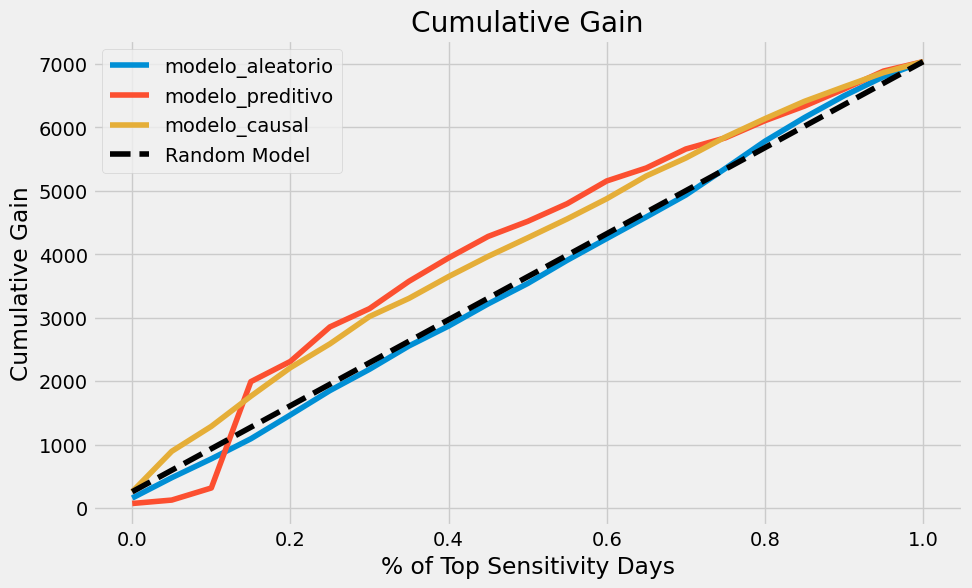

In [20]:
plt.figure(figsize=(10,6))

for m in ["modelo_aleatorio", "modelo_preditivo", "modelo_causal"]:
    cumu_gain = cumulative_gain(test_pred, m, min_periods=10, steps=20)
    x = np.array(range(len(cumu_gain)))
    plt.plot(x/x.max(), cumu_gain, label=m)

plt.plot([0, 1], [cumu_gain.min(), cumu_gain.max()], linestyle="--", label="Random Model", color="black")

plt.xlabel("% of Top Sensitivity Days")
plt.ylabel("Cumulative Gain")
plt.title("Cumulative Gain")
plt.legend();

# Política de decisão

In [21]:
roi_current = test_pred[test_pred['tech_support'] == 1]['retorno'].sum()
roi_optimal = test_pred[test_pred['retorno'] > 0]['retorno'].sum()
roi_all_receive = test_pred['retorno'].sum()

effect = np.multiply(estimate.estimator.effect(test_pred[covariates]), test_pred['tech_support'].to_numpy().reshape(-1,1))
Y_baseline = (test_pred['revenue'].to_numpy().reshape(-1,1) - effect).sum()

all_rois = np.array([roi_optimal, roi_current, roi_all_receive])

pd.DataFrame(
    {
        "Policy": ["Optimal", "Current", "All Investments"],
        "ROI ($)": all_rois,
        "ROI (% of baseline Y)": np.round(all_rois / Y_baseline * 100, 1),
    }
)

,Policy,ROI ($),ROI (% of baseline Y)
0,Optimal,1.402541e+06,35.2
1,Current,4.469717e+05,11.2
2,All Investments,7.372156e+05,18.5
